In [428]:
import os, pickle
import pandas as pd
import numpy as np
import scanpy as sc
import matplotlib
import matplotlib.pyplot as plt

from sklearn.decomposition import PCA
from imagegrains import segmentation_helper
from cellpose import models
from sklearn.neighbors import KNeighborsClassifier
from openTSNE import TSNE
import warnings
warnings.filterwarnings('ignore')

In [429]:
def inference_for_tsne(do_inference=True, TAR_DIR ='F:/cellpose/tsne/preds',model = 'F:/git/grain_seg_ml/models/full_set_1.170223',im_paths=['F:/cellpose/full_set/train', 'F:/cellpose/full_set/test']):
    if TAR_DIR is not None:
        os.makedirs(TAR_DIR, exist_ok=True)
    if do_inference == True:
        model = models.CellposeModel(gpu=True,pretrained_model=model)
        res=[segmentation_helper.predict_folder(im_paths[i],model,min_size=-1,TAR_DIR=TAR_DIR,return_results=True, mute=True) for i in range(len(im_paths))]

        train_styles= [res[0][2][i] for i in range(len(res[0][2]))]
        trainnames = [res[0][3][i] for i in range(len(res[0][2]))]
        test_styles= [res[1][2][i] for i in range(len(res[1][2]))]
        testnames = [res[1][3][i] for i in range(len(res[1][2]))]
        res_dict = {'train':train_styles, 'train_ids':trainnames, 'test':test_styles, 'test_ids':testnames}
        with open(f'res_tSNE.pkl', 'wb') as handle:
            pickle.dump(res_dict, handle)
    else:
        pkl_file = open(f'res_tSNE.pkl', 'rb')
        tres = pickle.load(pkl_file)
        train_styles = tres['train']
        trainnames = tres['train_ids']
        test_styles = tres['test']
        testnames = tres['test_ids']
        pkl_file.close()
    return train_styles, trainnames, test_styles, testnames

In [430]:
train_styles, trainnames, test_styles, testnames = inference_for_tsne(do_inference = False)

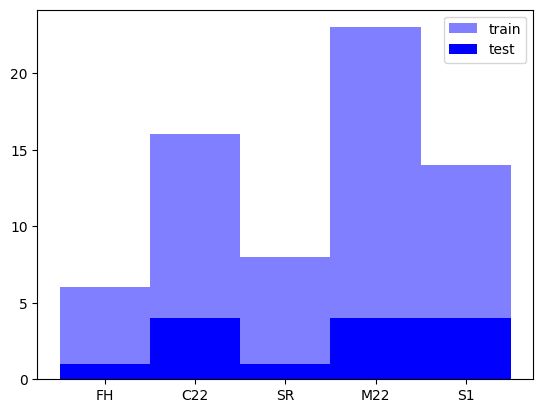

In [431]:
# Add data tags
C22_keys = ['kanaka','DS8','deer','hidden']
M22_keys = ['L2','K1','S9']
S1_keys = ['S1']
FH_keys = ['P106']
SR_keys = ['GU','Luet','Rhein','Simme','Thur']
source_tags,set_tags = [],[]
split_tags = [trainnames,testnames]

for idx, split in enumerate(split_tags):
    for name in split:
        if any (x in name for x in C22_keys):
            cl_name='C22'
            set_tag = 'APF'
        elif any (x in name for x in M22_keys):
            cl_name='M22'
            set_tag = 'APF'
        elif any (x in name for x in S1_keys):
            cl_name='S1'
            set_tag = 'S1'
        elif any (x in name for x in FH_keys):
            cl_name='FH'
            set_tag = 'FH'
        elif any (x in name for x in SR_keys):
            cl_name='SR'
            set_tag = 'APF'
        else:
            cl_name='unknown'
            set_tag = 'APF'
        source_tags.append(cl_name)
        set_tags.append(set_tag)
plt.hist(source_tags[0:len(trainnames)], bins=np.arange(6)-0.5,color='b',alpha=0.5,label='train')
plt.hist(source_tags[len(trainnames):],bins=np.arange(6)-0.5,color='b',label='test')
plt.legend();

In [432]:
#concatenate train and test data
styles = train_styles + test_styles
styles = np.array(styles)
names = trainnames + testnames
split_tags = ["train"]*len(trainnames) + ["test"]*len(testnames)
# Create anndata object for scanpy
adata = sc.AnnData(styles)
adata.obs_names= names
# Add data tags
adata.obs["source"]=source_tags 
adata.obs["split"] = split_tags
adata.obs["set"] = set_tags
print(adata)

AnnData object with n_obs × n_vars = 81 × 256
    obs: 'source', 'split', 'set'


In [433]:
#set parameters
n_components = 3
random_state = 42
n_neighbors = 66
perplexity = 22
resolution = .8

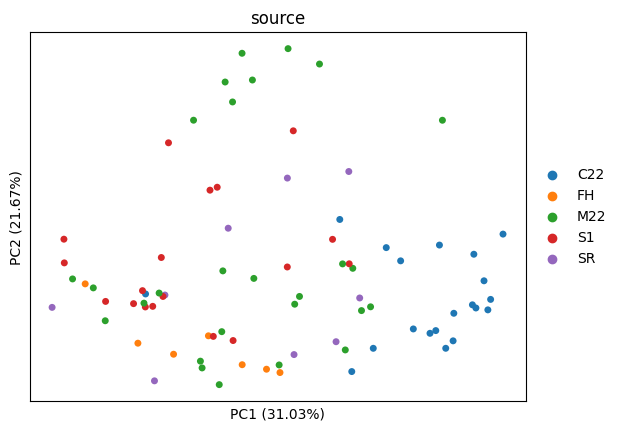

In [434]:
#PCA with scanpy


sc.tl.pca(adata)
sc.pl.pca(adata,color='source', annotate_var_explained ='scatter_bulk',size=100)

#neighbourhoods
sc.pp.neighbors(adata, n_neighbors=n_neighbors, n_pcs=n_components)
#UMAP
sc.tl.umap(adata)
#tSNE
sc.tl.tsne(adata, n_pcs=n_components,metric='cosine',random_state=random_state,perplexity=perplexity)

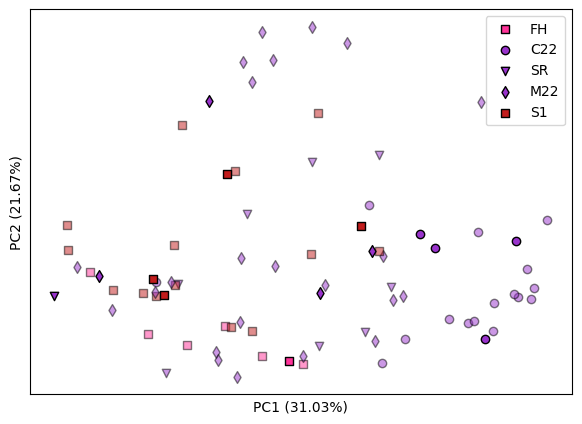

In [435]:
#sanity check with sklearn
pca = PCA(n_components=n_components)
pca.fit(styles)
X=pca.transform(styles)
colors = [[0.6,0.2,0.8], [0.760784314,0.109803922,0.109803922], [1,0.2,0.6],"pink","gold"]
target_names = ['C22','M22','FH','SR','S1']
markers = ['o','d','s','v','s']

plt.figure(figsize=(7,5))
lw = 1
for point in range(len(X)):
    if split_tags[point]=='train':
        a = .5
    elif split_tags[point]=='test':
        a = 1
    if set_tags[point]=='APF':
        c = colors[0]
    elif set_tags[point]=='S1':
        c = colors[1]
    elif set_tags[point]=='FH':
        c = colors[2]
    if source_tags[point]=='C22':
        m=markers[0]
    elif source_tags[point]=='M22':
        m=markers[1]
    elif source_tags[point]=='FH':
        m=markers[2]
    elif source_tags[point]=='SR':
        m=markers[3]
    elif source_tags[point]=='S1':
        m=markers[4]
    else:
        c='black'
    plt.scatter(X[point, 0], X[point, 1],color=c, marker = m,alpha=a, lw=lw,label=source_tags[point],edgecolor='k')

from collections import OrderedDict

handles, labels = plt.gca().get_legend_handles_labels()
by_label = OrderedDict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys());
plt.yticks(())
plt.xticks(())
plt.ylabel(f'PC2 ({np.round(pca.explained_variance_ratio_[1]*100,2)}%)')
plt.xlabel(f'PC1 ({np.round(pca.explained_variance_ratio_[0]*100,2)}%)');

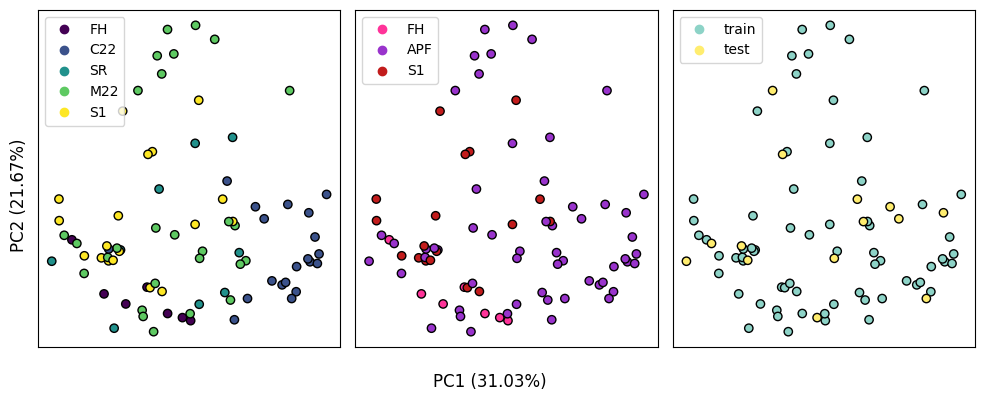

In [436]:
#Detailed PCAs
sources = pd.factorize(source_tags)
sets = pd.factorize(set_tags)
splits = pd.factorize(split_tags)

fig, axs = plt.subplots(1,3,figsize=(10,4))
sourceplot = axs[0].scatter(X[:, 0], X[:, 1], c=sources[0],edgecolor='k')
handles,labels=sourceplot.legend_elements()
axs[0].legend(handles, sources[1],loc='upper left')

setplot = axs[1].scatter(X[:, 0], X[:, 1], c=sets[0],edgecolor='k',cmap=matplotlib.colors.ListedColormap([[1,0.2,0.6],[0.6,0.2,0.8],[0.760784314,0.109803922,0.109803922]]))
handles,labels=setplot.legend_elements()
axs[1].legend(handles, sets[1],loc='upper left')

splitplot = axs[2].scatter(X[:, 0], X[:, 1], c=splits[0],edgecolor='k',cmap='Set3')
handles,labels=splitplot.legend_elements()
axs[2].legend(handles, splits[1],loc='upper left')

plt.setp(axs, xticks=(), yticks=())
fig.supxlabel(f'PC1 ({np.round(pca.explained_variance_ratio_[0]*100,2)}%)')
fig.supylabel(f'PC2 ({np.round(pca.explained_variance_ratio_[1]*100,2)}%)')
plt.tight_layout()

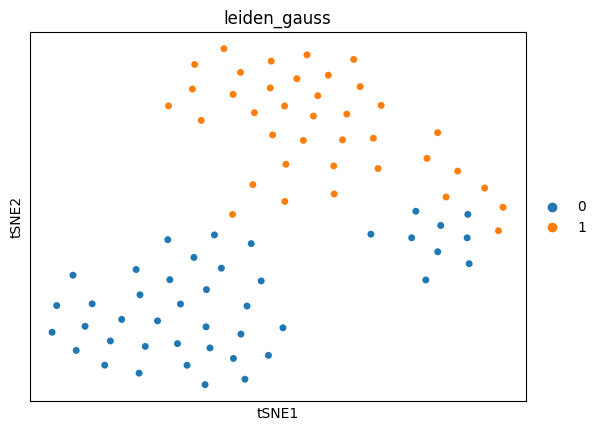

0    43
1    38
Name: leiden_gauss, dtype: int64


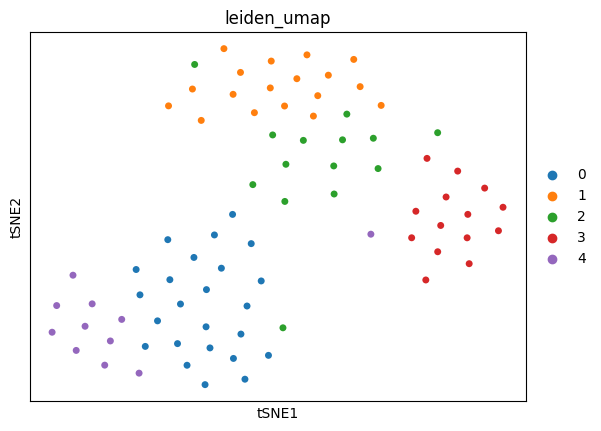

0    24
1    18
2    14
3    14
4    11
Name: leiden_umap, dtype: int64


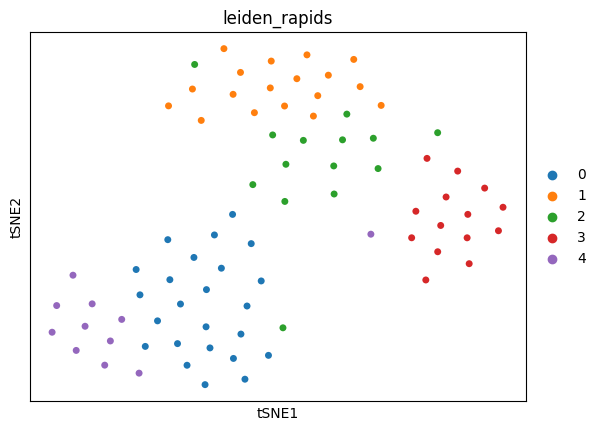

0    24
1    18
2    14
3    14
4    11
Name: leiden_rapids, dtype: int64


In [437]:
method_l = ['gauss','umap','rapids']
for k in range(3):
    #neighborhood graph https://scanpy.readthedocs.io/en/latest/generated/scanpy.pp.neighbors.html#scanpy-pp-neighbors
    sc.pp.neighbors(adata, n_neighbors=n_neighbors, n_pcs=n_components,method=method_l[k],key_added=str(method_l[k])+'_neighbors',knn=True)
    #clustering using the leiden algorithm https://scanpy.readthedocs.io/en/latest/generated/scanpy.tl.leiden.html#scanpy-tl-leiden
    sc.tl.leiden(adata, resolution=resolution, neighbors_key=str(method_l[k])+'_neighbors',key_added='leiden_'+str(method_l[k]))
    sc.pl.tsne(adata, color=['leiden_'+str(method_l[k])],size=100)
    print(adata.obs['leiden_'+str(method_l[k])].value_counts())

Using the code of Stringer & Pachitariu (2022) from 
https://github.com/MouseLand/cellpose/blob/main/paper/2.0/train_specialists.py

In [438]:
U = PCA(n_components=n_components).fit_transform(styles)
tsne = TSNE(    
                neighbors= 'exact',
                perplexity=perplexity,
                metric='cosine',
                n_jobs=8,
                random_state=random_state,
                verbose = False,
                n_components = n_components,
                initialization = .0001 * U,
            )
embeddingOPENTSNE = tsne.fit(styles)
x=embeddingOPENTSNE[:,0]
y=embeddingOPENTSNE[:,1]

#adata = sc.AnnData(styles)
sc.pp.neighbors(adata, n_neighbors=n_neighbors, use_rep='X')
sc.tl.leiden(adata, resolution=resolution)
leiden_labels = np.array(adata.obs['leiden'].astype(int))

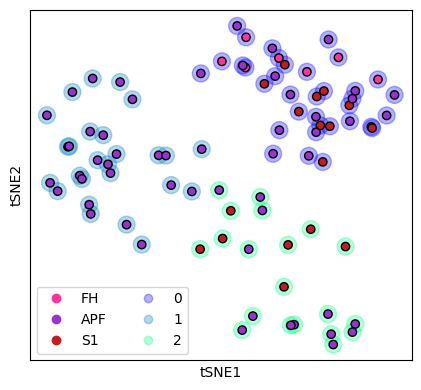

In [443]:
fig, axs = plt.subplots(1,1, figsize=(6,4))

clusterplot = axs.scatter(x,y,s=150,c=leiden_labels,alpha=.3,cmap='winter')

sourceplot = axs.scatter(x,y,c=sets[0],edgecolor='k',cmap=matplotlib.colors.ListedColormap([[1,0.2,0.6],[0.6,0.2,0.8],[0.760784314,0.109803922,0.109803922]]))

handles,labels=sourceplot.legend_elements()
handles2,labels=clusterplot.legend_elements()
handles = handles + handles2
l = [str(np.unique(leiden_labels)[k]) for k in range(len(np.unique(leiden_labels)))]
s = [str(sets[1][k]) for k in range(len(sets[1]))]
axs.legend(handles, s+l,loc='lower left',ncol=2)

plt.setp(axs, xticks=(), yticks=(), xlabel='tSNE1',ylabel='tSNE2',aspect = 'equal')
#for (xi, yi, txt) in zip(x, y, names):
#    plt.text(xi, yi, txt, va='bottom', ha='center',fontsize=8)
plt.tight_layout()

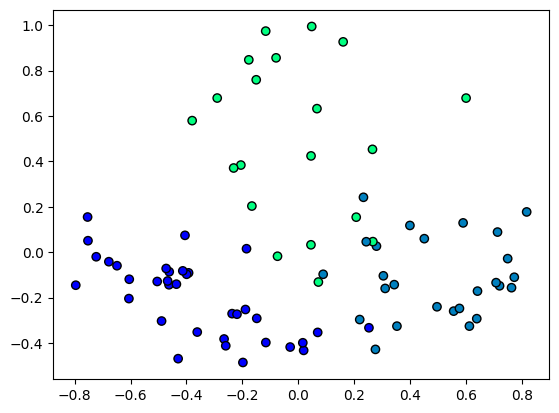

In [441]:
plt.scatter(X[:, 0], X[:, 1], c=leiden_labels,edgecolor='k',cmap='winter')